# Generate a prettier plot with statistics on the plot

In [1]:
library(repr)
library(ggpubr)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
config <- list('caudate'= '../../../_m/genes/diffExpr_szVctl_full.txt',
              'dlpfc'= '/ceph/projects/v4_phase3_paper/inputs/public_data/_m/phase2/dlpfc_diffExpr_szVctl_full.txt',
              'hippo'= '/ceph/projects/v4_phase3_paper/inputs/public_data/_m/phase2/hippo_diffExpr_szVctl_full.txt', 
              'cmc'=paste0("/ceph/projects/v4_phase3_paper/inputs/public_data/_m/cmc/CMC_MSSM-Penn-Pitt_DLPFC_mRNA_",
                           "IlluminaHiSeq2500_gene-adjustedSVA-differentialExpression-includeAncestry-DxSCZ-DE.tsv"),
              'cmc_noSVA'=paste0("/ceph/projects/v4_phase3_paper/inputs/public_data/_m/cmc/CMC_MSSM-Penn-Pitt_DLPFC_mRNA_",
                                 "IlluminaHiSeq2500_gene-adjustedNoSVA-differentialExpression-includeAncestry-DxSCZ-DE.tsv"))

In [12]:
get_deg <- function(fn){
    dft <- data.table::fread(fn)
    if('gene_id' %in% colnames(dft)){
        dft <- dft %>% 
            mutate(Feature=gene_id, Dir=sign(t)) %>% 
            rename(ensemblID=ensembl_gene_id) %>%
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    } else if ('gencodeID' %in% colnames(dft)){
        dft <- dft %>%
            mutate(Feature=gencodeID, Dir=sign(t)) %>%
            select("Feature", "ensemblID", "adj.P.Val", "logFC", "t", "Dir")
    } else if ('MAPPED_genes' %in% colnames(dft)){
        dft <- dft %>% 
            mutate(Feature=genes, ensemblID=genes, Dir=sign(t)) %>%
            select("Feature", "ensemblID", "adj.P.Val", "logFC", "t", "Dir")
    } else {
        dft <- dft %>% 
            mutate(Feature=V1, Dir=sign(dft$t)) %>% 
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    }
    return(dft)
}

get_deg_sig <- function(fn, fdr){
    dft <- get_deg(fn)
    return(subset(dft, adj.P.Val < fdr))
}

merge_dataframe <- function(tissue1, tissue2){
    return(merge(get_deg(config[[tissue1]]), get_deg(config[[tissue2]]), 
                 by='ensemblID', suffixes=c(paste0('_',tissue1), paste0('_',tissue2))))
}

merge_dataframes_sig <- function(tissue1, tissue2){
    fdr1 = ifelse(tissue1 != 'dlpfc', 0.05, 0.05)
    fdr2 = ifelse(tissue2 != 'dlpfc', 0.05, 0.05)
    return(merge(get_deg_sig(config[[tissue1]], fdr1), get_deg_sig(config[[tissue2]], fdr2), 
                 by='ensemblID', suffixes=c(paste0('_',tissue1), paste0('_',tissue2))))
}

tissue_annotation <- function(tissue){
    return(list('dlpfc'='DLPFC', 'hippo'='Hippocampus', 
                'caudate'='Caudate', 'cmc'="CMC DLPFC", 
                "cmc_noSVA"="CMC DLPFC [no SVA]")[[tissue]])
}

get_scatter_plot <- function(tissue1, tissue2, merge_fnc, coords){
    dft <- merge_fnc(tissue1, tissue2)
    sp = ggscatter(dft, x=paste0('t_', tissue1), y=paste0('t_', tissue2), add="reg.line", 
                   xlab=paste0('T-statistic (',tissue_annotation(tissue1), ')'),
                   ylab=paste0('T-statistic (',tissue_annotation(tissue2), ')'),
                   add.params=list(color="blue", fill="lightgray"), conf.int=TRUE, 
                   cor.method="pearson", cor.coef=FALSE, cor.coef.size=7, 
                   cor.coeff.args=list(label.sep="\n"), ylim=c(-6,8), 
                   ggtheme=theme_pubr(base_size=20)) + 
        stat_cor(aes(label=..rr.label..), label.sep='\n', size=8, 
                 method="spearman",  label.x=-8, label.y=7) +
        font("xylab", face='bold')
    return(sp)
}


save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## BrainSeq Comparison

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



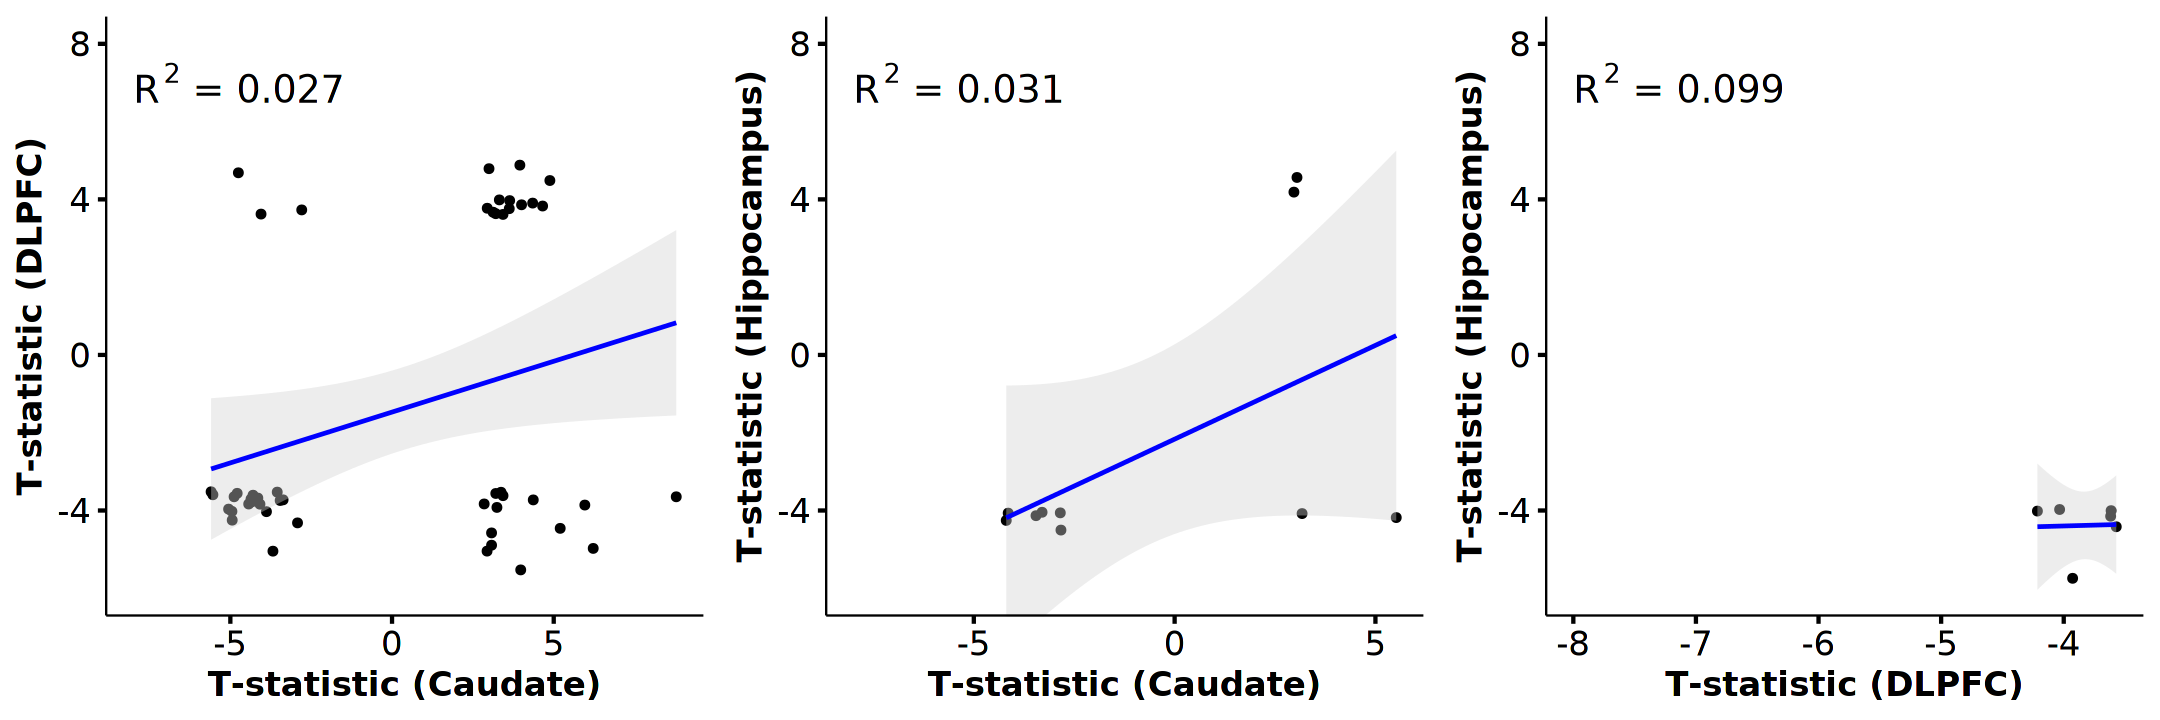

In [6]:
options(repr.plot.width=18, repr.plot.height=6)
sp1_sig = get_scatter_plot('caudate', 'dlpfc', merge_dataframes_sig, c(-110, 85))
sp2_sig = get_scatter_plot('caudate', 'hippo', merge_dataframes_sig, c(-110, 85))
sp3_sig = get_scatter_plot('dlpfc', 'hippo', merge_dataframes_sig, c(-110, 85))
fig1 = ggarrange(sp1_sig, sp2_sig, sp3_sig, ncol=3, nrow=1, align='v')
print(fig1)

In [6]:
save_ggplots("tstatistic_corr_sig", fig1, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



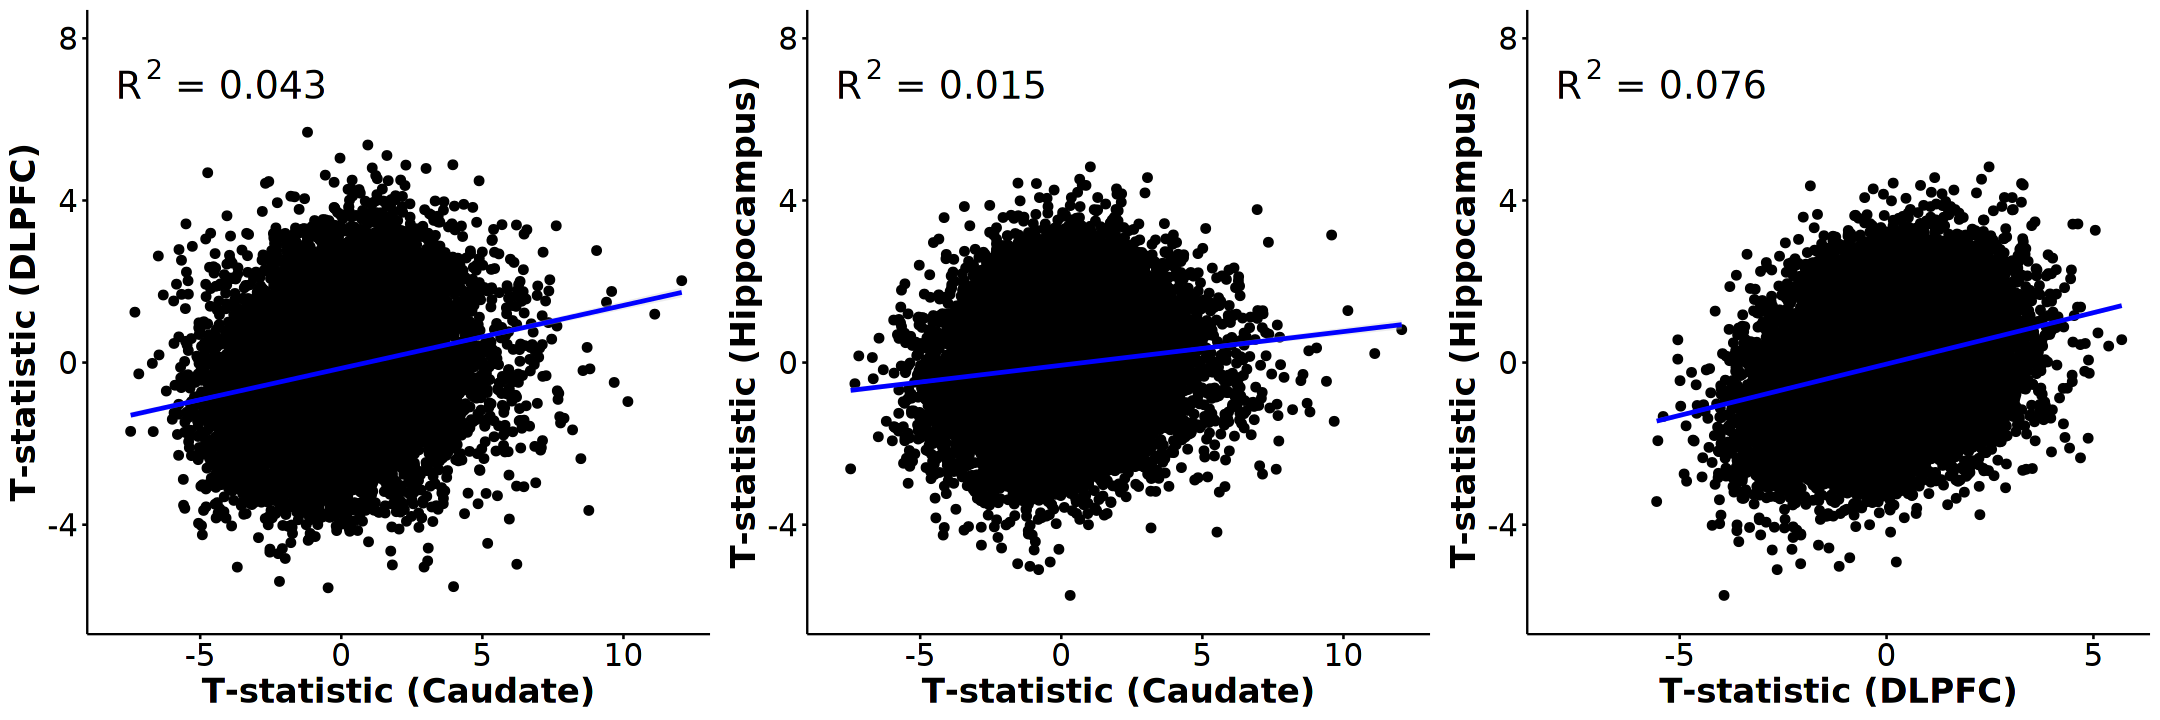

In [22]:
sp1 = get_scatter_plot('caudate', 'dlpfc', merge_dataframe, c(-110, 85))
sp2 = get_scatter_plot('caudate', 'hippo', merge_dataframe, c(-110, 85))
sp3 = get_scatter_plot('dlpfc', 'hippo', merge_dataframe, c(-110, 85))
fig2 = ggarrange(sp1, sp2, sp3, ncol=3, nrow=1, align='v')
print(fig2)

In [12]:
save_ggplots("tstatistic_corr", fig2, 18, 6)

file saved to tstatistic_corr.pdf

file saved to tstatistic_corr.png



## CMC Comparison

### SVA correction

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



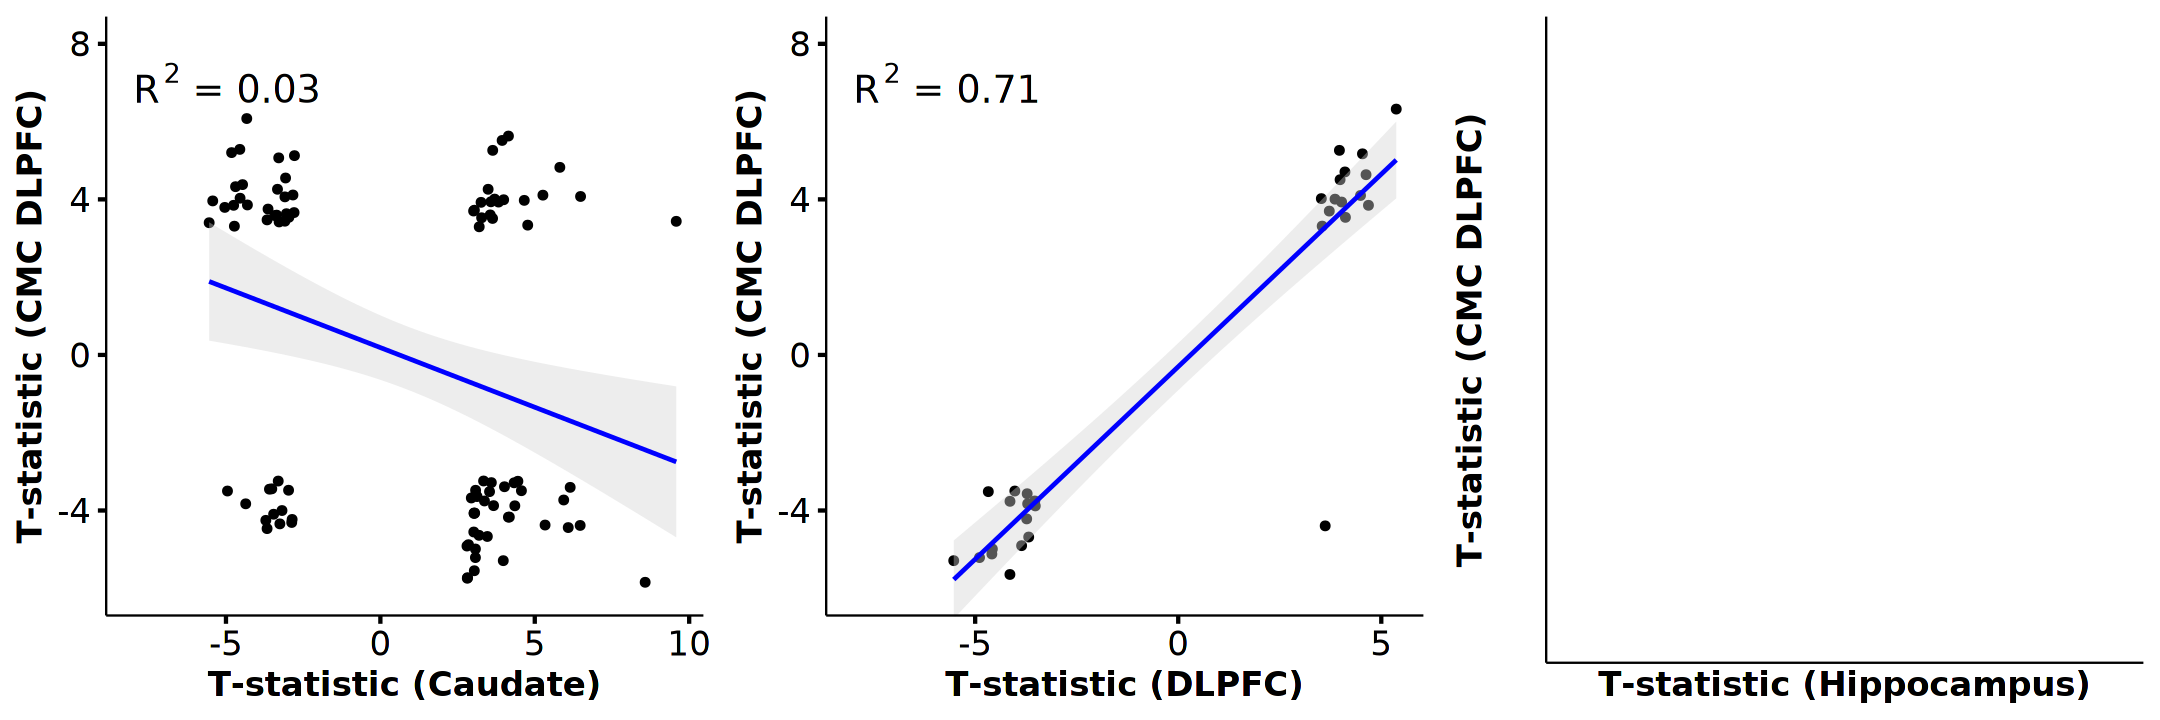

In [10]:
options(repr.plot.width=18, repr.plot.height=6)
sp1_sig = get_scatter_plot('caudate', 'cmc', merge_dataframes_sig, c(-110, 85))
sp2_sig = get_scatter_plot('dlpfc', 'cmc', merge_dataframes_sig, c(-110, 85))
sp3_sig = get_scatter_plot('hippo', 'cmc', merge_dataframes_sig, c(-110, 85))
fig1 = ggarrange(sp1_sig, sp2_sig, sp3_sig, ncol=3, nrow=1, align='v')
print(fig1)

In [6]:
save_ggplots("cmc_tstatistic_corr_sig", fig1, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



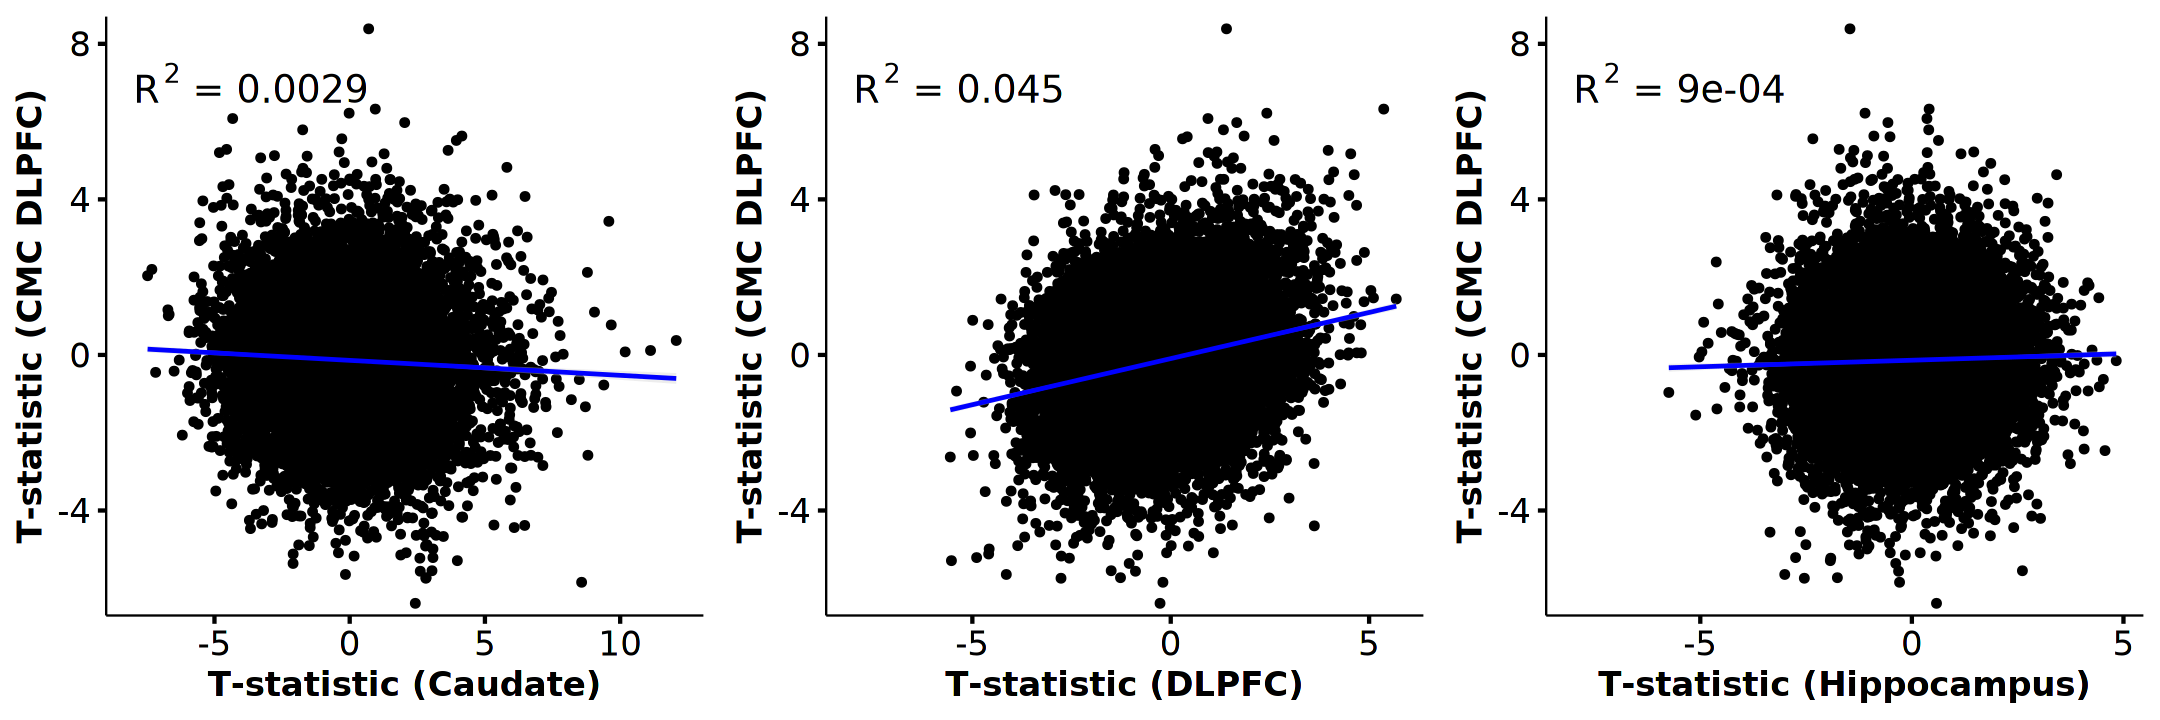

In [13]:
sp1 = get_scatter_plot('caudate', 'cmc', merge_dataframe, c(-110, 85))
sp2 = get_scatter_plot('dlpfc', 'cmc', merge_dataframe, c(-110, 85))
sp3 = get_scatter_plot('hippo', 'cmc', merge_dataframe, c(-110, 85))
fig2 = ggarrange(sp1, sp2, sp3, ncol=3, nrow=1, align='v')
print(fig2)

In [12]:
save_ggplots("cmc_tstatistic_corr", fig2, 18, 6)

file saved to tstatistic_corr.pdf

file saved to tstatistic_corr.png



### No SVA correction

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message in qt((1 - level)/2, df):
"NaNs produced"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


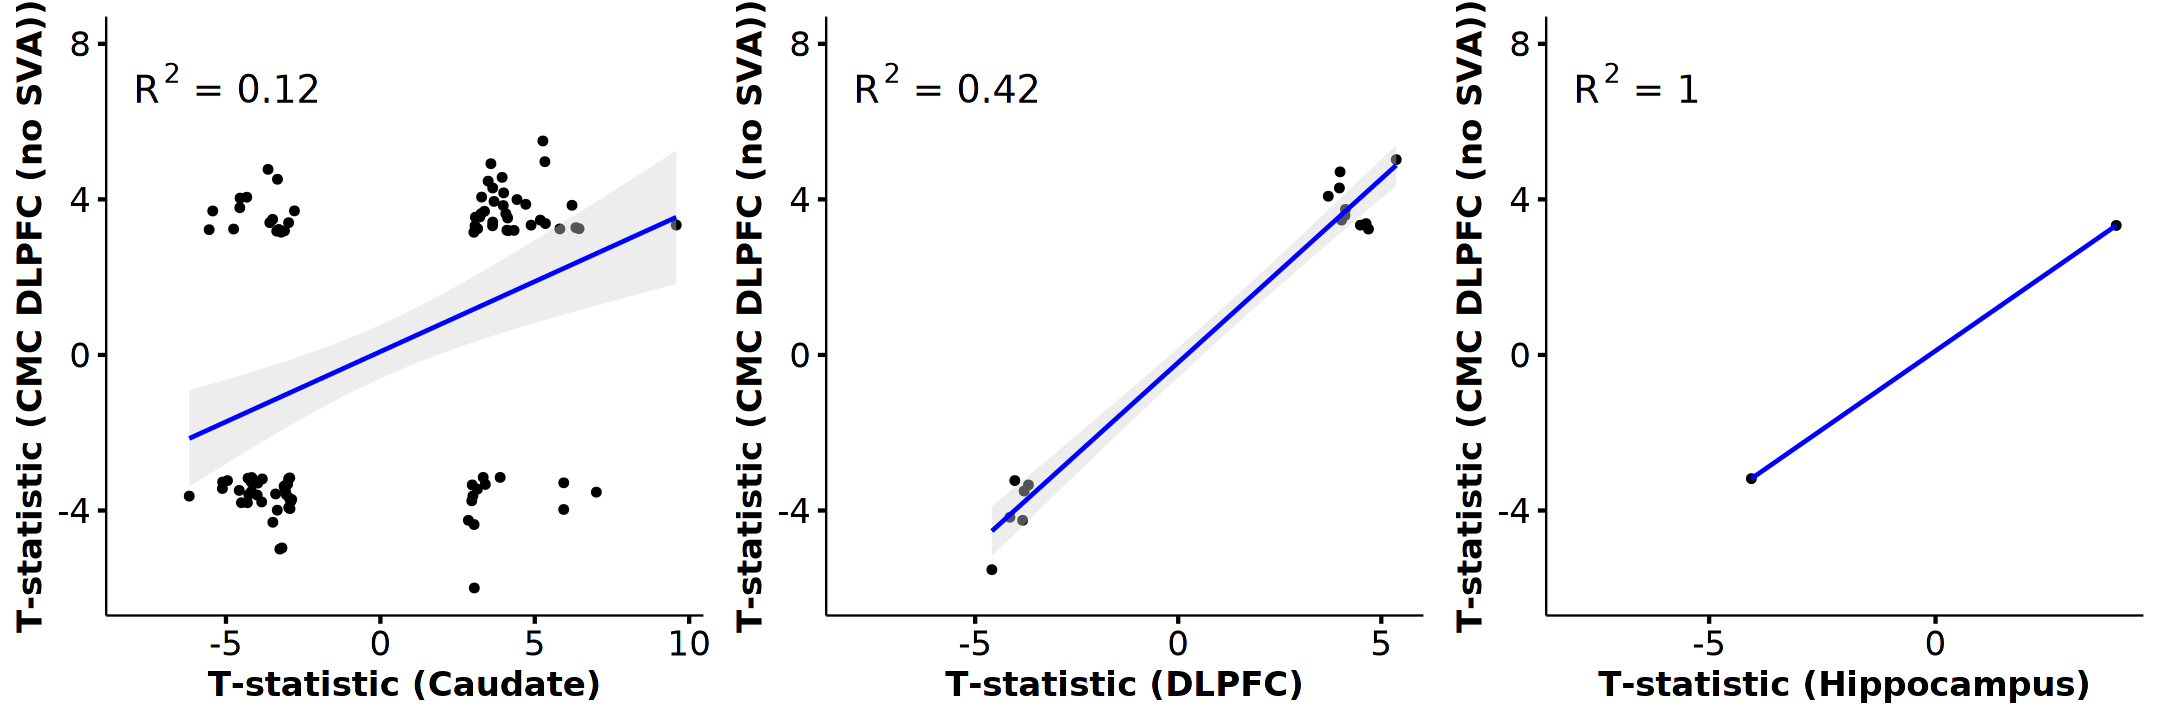

In [14]:
options(repr.plot.width=18, repr.plot.height=6)
sp1_sig = get_scatter_plot('caudate', 'cmc_noSVA', merge_dataframes_sig, c(-110, 85))
sp2_sig = get_scatter_plot('dlpfc', 'cmc_noSVA', merge_dataframes_sig, c(-110, 85))
sp3_sig = get_scatter_plot('hippo', 'cmc_noSVA', merge_dataframes_sig, c(-110, 85))
fig1 = ggarrange(sp1_sig, sp2_sig, sp3_sig, ncol=3, nrow=1, align='v')
print(fig1)

In [6]:
save_ggplots("cmc_noSVA_tstatistic_corr_sig", fig1, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



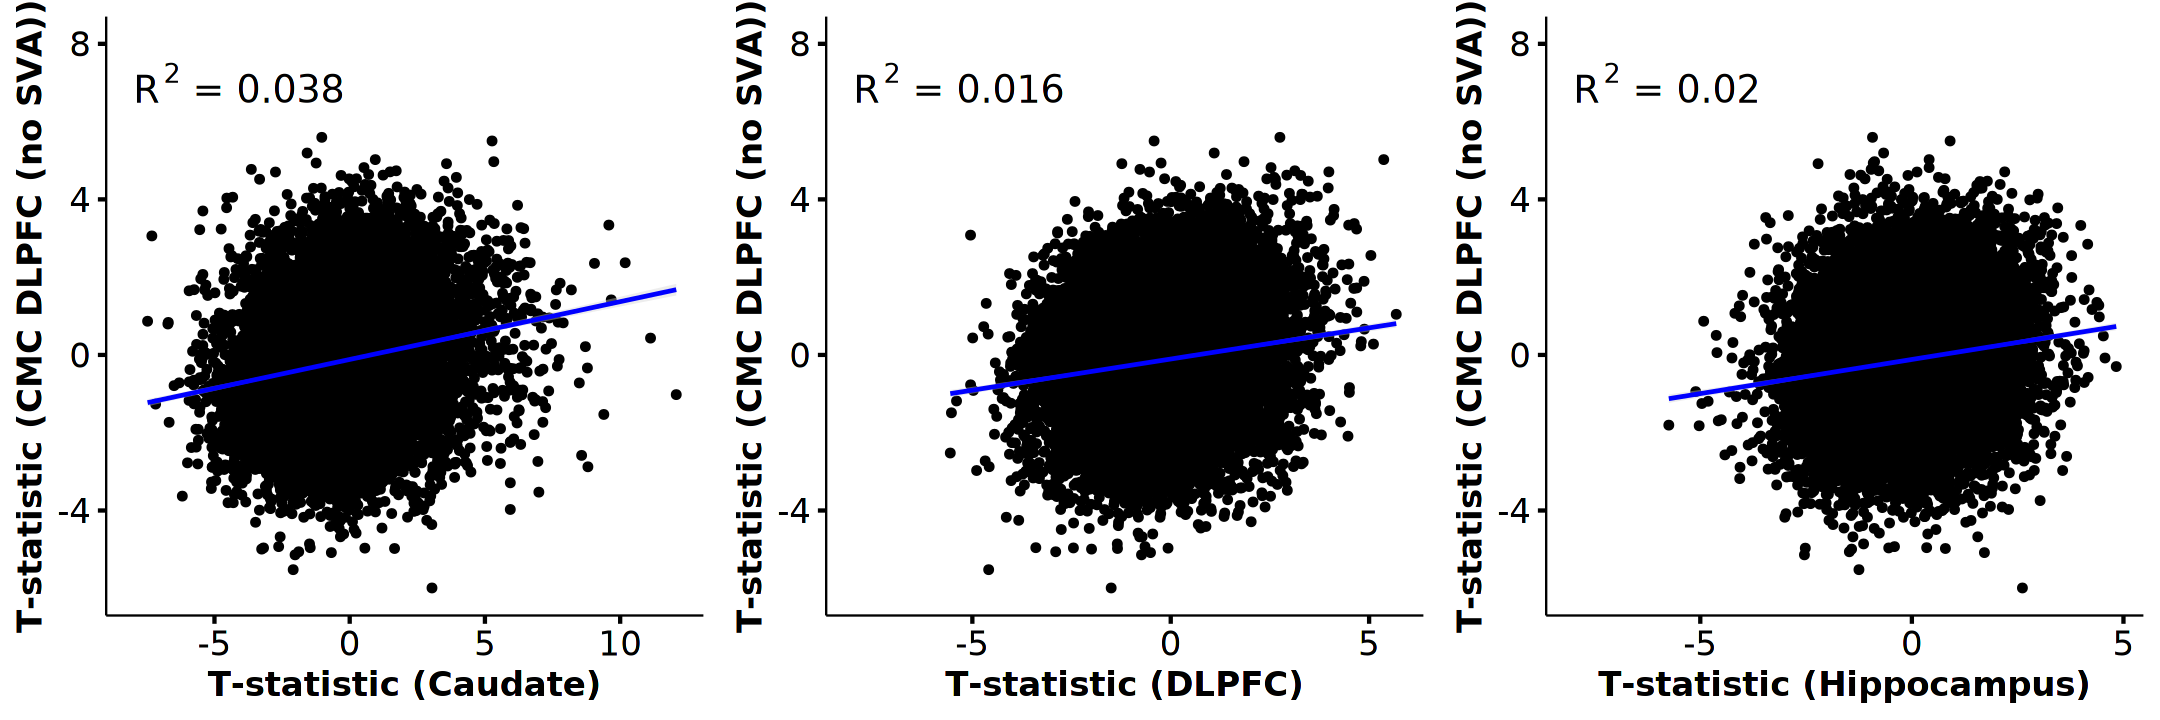

In [15]:
sp1 = get_scatter_plot('caudate', 'cmc_noSVA', merge_dataframe, c(-110, 85))
sp2 = get_scatter_plot('dlpfc', 'cmc_noSVA', merge_dataframe, c(-110, 85))
sp3 = get_scatter_plot('hippo', 'cmc_noSVA', merge_dataframe, c(-110, 85))
fig2 = ggarrange(sp1, sp2, sp3, ncol=3, nrow=1, align='v')
print(fig2)

In [12]:
save_ggplots("cmc_noSVA_tstatistic_corr", fig2, 18, 6)

file saved to tstatistic_corr.pdf

file saved to tstatistic_corr.png



## Reproducibility Information

In [ ]:
print("Reproducibility Information:")
Sys.time()
proc.time()
options(width=120)
sessioninfo::session_info()